# Scraping play-by-play data from stats.nba.com

We define two methods, one using BeautifulSoup and the other using the stats.nba.com API (via http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/).

We use the API method.

The BeautifulSoup method is preserved for reference.

We use the EVENTMSGTYPE column because it encodes the action information. See DOCS.md for details.

## Method 2 - with stats.nba.com API

In [2]:
import requests
import pandas as pd
import numpy as np
from IPython.display import display

# dont hide columns when displaying dataframe
pd.set_option('display.max_columns', None)

## Get the data

In [4]:
# get playbyplay data
# needs an internet connection

playbyplay_url = 'http://stats.nba.com/stats/playbyplayv2?EndPeriod=10&EndRange=55800&GameID=0041500314&RangeType=2&Season=2015-16&SeasonType=Playoffs&StartPeriod=1&StartRange=0'

# request the URL and parse the JSON
response = requests.get(playbyplay_url)
response.raise_for_status() # raise exception if invalid response
header = response.json()['resultSets'][0]['headers']
plays = response.json()['resultSets'][0]['rowSet']

# get the playbyplay data in a dataframe
df_raw = pd.DataFrame(plays, columns=header)

## Pre-processing data (including handling missing data)

In [5]:
# propagate score so that every table has the appropriate score

# set first score to 0-0
df_raw.set_value(0,'SCORE',"0 - 0")
# forward-propagate
df_raw.SCORE.fillna(method='ffill', inplace=True)


# regularize eventnum (sometimes jumps a few)
# make it match df line
df_raw['EVENTNUM'] = pd.Series(df_raw.index)

# create final dataframe with relevant information only

relevant_columns = ["EVENTNUM", "EVENTMSGTYPE", "EVENTMSGACTIONTYPE"]
df = df_raw[relevant_columns]

## Create one-hot encoded event vectors
Example: if one event is EVENTNUM=2, then it will be represented by the vector v=[0 0 1 0 0 0  ... 0]

In [6]:
# get timeout events ID: those that match EVENTMSGTYPE=9

timeout_events_df = df[(df.EVENTMSGTYPE==9) & ((df.EVENTMSGACTIONTYPE==1) | (df.EVENTMSGACTIONTYPE==2))]
timeout_events = list(timeout_events_df["EVENTNUM"])
num_timeout_events = len(timeout_events)
timeout_events

[47, 60, 99, 142, 195, 225, 274, 307, 330, 372, 431, 467, 483]

In [26]:
# create OHE df
from tilestools import event_to_OHE

num_features = max(df.EVENTMSGTYPE) + 1 # account for EVENTMSGTYPE=0
df_ohe = pd.DataFrame([event_to_OHE(x, num_features) for x in df.EVENTMSGTYPE])

df_ohe[df_ohe[9]==1.]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# create design matrix X and labels y

# we define a window of size K and select every set of K points as a training example
# the label is whether the index of the next event is a timeout or not

# this assumes that there wasn't a timeout in the first K events

K = 10

num_events = len(df_ohe)
num_training_examples = num_events-K

X = np.zeros((num_training_examples, num_features))

idx=0
for event_id in range(K,num_events):
    before_events = df_ohe.iloc[event_id-K:event_id]
    X[idx,:] = sum(before_events)
    idx+=1
    
# labels
# create list of timeout events indexes in new setting
# e.g. if K=10 and the 11th event was a timeout, then y[0] must be 1
timeout_events_idx = [idx-K for idx in timeout_events]

# create labels
y = zeros(num_training_examples)
y[timeout_events_idx] = 1.0



assert len(X) == len(y)

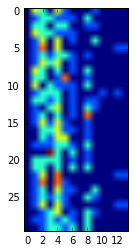

In [9]:
## Visualizing X
## select N random training examples to visualize

N = 30

idx = np.random.choice(range(len(X)), size=N, replace=False)
plt.imshow(X[idx])

## Learning

First we must set up cross-validation to understand how our model is performing.

Because we have very skewed data, i.e. many examples of one class (non-timeout) and few of the other (timeout), we cannot simply randomly split the data into training and test sets because we run the risk of putting very few (or none at all) positive examples in one of the sets.

To address this problem we do something called stratified sampling, which simply means selecting data points randomly but preserving the relative class frequencies.

So for example, say we have 1000 data points where 10 are positive examples and 990 are negative examples. We want to split the data in 80% training and 20% test data. Then what we do is we randomly select 80% of the 990 negative examples, plus 80% of the 10 positive example, and that is our training set; the remaining 20% of the 990 negative examples plus 20% of the 10 positive examples are our test set.

This we we at least ensure we're not making the problem of over-representation of one class even worse.

In [12]:
# let's start by standardizing our features

from sklearn.preprocessing import StandardScaler

# standardize features
sc = StandardScaler(copy=False)
sc.fit_transform(X);

In [13]:
# we'll split our data in 80-20 fashion
# because we're dealing with skewed classes, must use stratified sampling
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, stratify=y)

# make sure proportions are kept
print ((y==1).mean())
print ((y_train==1).mean())
print ((y_test==1).mean())
print ((y==0).mean())
print ((y_train==0).mean())
print ((y_test==0).mean())

0.025641025641
0.0246913580247
0.0294117647059
0.974358974359
0.975308641975
0.970588235294


Let's train our first model - Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression

# fit model
model = LogisticRegression()
model.fit(X_train,y_train);


Cool, let's see training and test scores (mean accuracy)


In [15]:
print(model.score(X_train,y_train))
print(model.score(X_test, y_test))


0.975308641975
0.970588235294


Hey, looks pretty good!

Wait a minute... 

In [16]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
print(y_test_predicted)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Ok so this model is just predicting zeros for everything. Not very useful

We can use precision and recall to better evaluate its performance

Could we also train it to optimize these costs, rather than the typical logloss?

In [18]:
# use precision and recall metrics
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_test_predicted)
recall = recall_score(y_test, y_test_predicted)

precision = precision_score(y_train, y_train_predicted)
recall = recall_score(y_train, y_train_predicted)

print (precision, recall)

0.0 0.0


/Users/joaopcoelho/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
# use PR-score
# from now on, this is what we'll use to evaluate models

from tilestools import PRscore
PRscore(y_test, y_test_predicted)

/Users/joaopcoelho/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

Well, shit.



So, where to go now:

1. We clearly need more data - get data from other games
2. We clearly need better data - separate features into for and against
3. We probably need a better model - would be nice to train with precision/recall rather than accuracy

# Reference code

Code not used

## Method 1 - with BeautifulSoup
Not used


In [15]:
# get all the info in the website, via inspecting the html code
# not used 

from bs4 import BeautifulSoup
import requests

import pandas as pd

url = "http://stats.nba.com/game/#!/0041500314/playbyplay/"
r  = requests.get(url)

data = r.text
soup = BeautifulSoup(data)
#print(soup.prettify())

table = soup.find('table', attrs={'class': "table"})
#print(table)


rows = table.findAll('tr')
for tr in rows:
    cols = tr.findAll('td')
    for td in cols:
        text = td.find(text=True) + ';'
#        print (text)


/Users/joaopcoelho/anaconda/envs/python3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html.parser")

  markup_type=markup_type))


In [16]:
# timeouts baby

df_home  = df[df.HOMEDESCRIPTION.notnull()]
df_home_timeouts=df_home[df_home.HOMEDESCRIPTION.str.contains("Timeout")]

df_away  = df[df.VISITORDESCRIPTION.notnull()]
df_away_timeouts=df_away[df_away.VISITORDESCRIPTION.str.contains("Timeout")]

AttributeError: 'DataFrame' object has no attribute 'HOMEDESCRIPTION'

In [ ]:
total_timeouts = pd.concat([df_home_timeouts, df_away_timeouts])

In [ ]:
total_timeouts.sort_values(by="EVENTNUM")[["EVENTMSGTYPE", "HOMEDESCRIPTION", "VISITORDESCRIPTION", "SCORE"]]

In [ ]:
# Explore data
# fields to explore: EVENTMSGACTIONTYPE, EVENTMSGTYPE

field_to_explore = "EVENTMSGTYPE"
fields_to_show = [field_to_explore] + ["EVENTMSGACTIONTYPE", "HOMEDESCRIPTION", "NEUTRALDESCRIPTION", "VISITORDESCRIPTION"]

a = df[fields_to_show]

max_ = df[field_to_explore].max()

from ipywidgets import interact

n=1
@interact(emat = (0,int(max_)))
def show_df(emat=n):
    display(a[a[field_to_explore] == emat])


In [ ]:
#df[df.HOMEDESCRIPTION.str.contains("Jump", na=False)]
